 # **Clasificación de imágenes de satélite**

### Data Science: Equipo 2

## **Introducción**

Nuestro proyecto se basa en la utilización de diferentes métodos de clasificación de imágenes de satélite, verificando qué método es el más óptimo de acuerdo al tiempo de cómputo y su precisión, en una arena de clasificadores. 

La libreta contiene datos del estado de Jalisco, las imágenes de satélite se descargaron del [siguiente repositorio](https://earthexplorer.usgs.gov/).

En este caso, las imágenes del satélite Landsat 8 en valores de reflectancia del terreno, con resolución de 30 metros y correspondientes parte de la zona metropolitana de Guadalajara y áreas aledañas, en el estado de Jalisco, México. La siguiente tabla presenta una descripción general de los datos.


| | |
| --- | --- |
| Satélite | Landsat 8 |
| Fecha de adquisición | 20-03-2018 |
| Altura | 1328  |
| Anchura | 643   |
| # de Bandas | 7 |
| Resolución espacial | 30 metros | 




## **I. Librerías y datos**

Para iniciar nuestra libreta vamos a llamar las primeras librerías de python, las cuales las usaremos para cargar nuestros datos, visualizar las imágenes, etc.

Es importante instalar **rasterio** para poder accesar y trabajar con los datos sin complicaciones.

In [15]:
!pip install rasterio

In [16]:
# Importar pandas para dataframes
import pandas as pd

# Importar librerías numéricas
import numpy as np

# Importar las dependencias usadas para el uso de imágenes de satélite 
import rasterio as rio

# Importar las librerías de graficación
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from rasterio.plot import show


In [17]:
# Importamos los datos desde Github
Landsat_data = []
for i in range(1,8):
    Landsat_data.append(f"https://github.com/zoegarm/Clasificacion-de-imagenes-de-satelite/blob/main/images_sat/jalisco_B{i}.tif?raw=true")


# Acomodamos los datos en orden de las bandas
Landsat_data.sort()

# Visualizamos el path de los archivos
Landsat_data

['https://github.com/zoegarm/Clasificacion-de-imagenes-de-satelite/blob/main/images_sat/jalisco_B1.tif?raw=true',
 'https://github.com/zoegarm/Clasificacion-de-imagenes-de-satelite/blob/main/images_sat/jalisco_B2.tif?raw=true',
 'https://github.com/zoegarm/Clasificacion-de-imagenes-de-satelite/blob/main/images_sat/jalisco_B3.tif?raw=true',
 'https://github.com/zoegarm/Clasificacion-de-imagenes-de-satelite/blob/main/images_sat/jalisco_B4.tif?raw=true',
 'https://github.com/zoegarm/Clasificacion-de-imagenes-de-satelite/blob/main/images_sat/jalisco_B5.tif?raw=true',
 'https://github.com/zoegarm/Clasificacion-de-imagenes-de-satelite/blob/main/images_sat/jalisco_B6.tif?raw=true',
 'https://github.com/zoegarm/Clasificacion-de-imagenes-de-satelite/blob/main/images_sat/jalisco_B7.tif?raw=true']

## **II. Preprocesamiento de imágenes y análisis exploratorio de datos**

A continuación realizamos la integración de las 7 bandas que componen la fotografía satelital final y mostramos dichas imágenes. Asimismo, presentamos el análisis exploratorio de estos datos con histogramas y boxplots.


In [18]:
# Realizamos un array con las 7 imágenes

imagenes = []
labels = []
for i in range(0,len(Landsat_data)):
  print(f"La banda {Landsat_data[i][-15:-13]}, está almacenada en la posición {[i]} del array")
  labels.append(Landsat_data[i][-6:-4])
  with rio.open(Landsat_data[i], 'r') as d:
    imagenes.append(d.read(1))

arr_img = np.stack(imagenes)
arr_img = np.moveaxis(arr_img, 0, -1)

# Ahora vamos a verificar el arreglo de nuestro array

print(f"La dimensión de nuestro array es:\n {arr_img.shape[2]} bandas (o canales)\n {arr_img.shape[0]} alto\n {arr_img.shape[1]} ancho")

La banda B1, está almacenada en la posición [0] del array
La banda B2, está almacenada en la posición [1] del array
La banda B3, está almacenada en la posición [2] del array
La banda B4, está almacenada en la posición [3] del array
La banda B5, está almacenada en la posición [4] del array
La banda B6, está almacenada en la posición [5] del array
La banda B7, está almacenada en la posición [6] del array
La dimensión de nuestro array es:
 7 bandas (o canales)
 1328 alto
 643 ancho


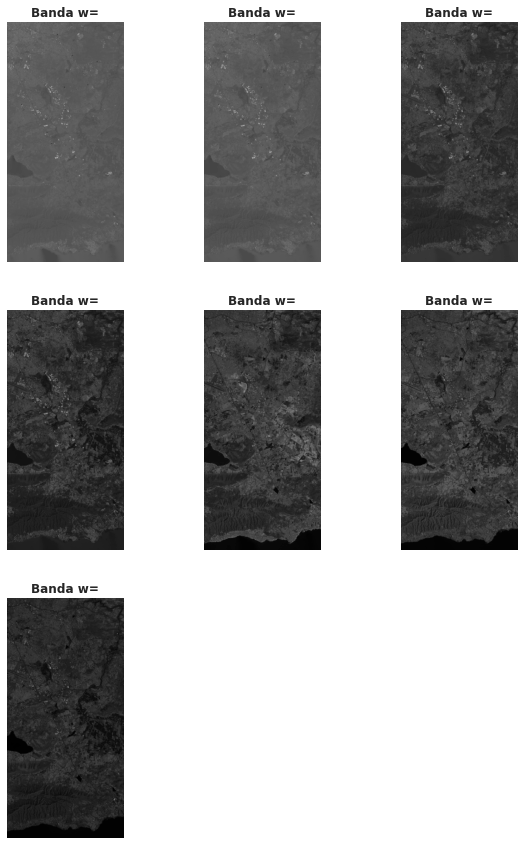

In [19]:
# Vamos a mostrar las imágenes de satélite por cada banda
sns.set(style="white")
fig = plt.figure(figsize=(10, 15))
for i in range(1, len(labels) + 1 ):
    ax = fig.add_subplot(3, 3, i)
    show(arr_img[:,:,i-1], cmap='Greys_r', ax=ax, title=f"Banda {labels[i-1]}")
    plt.axis('off')

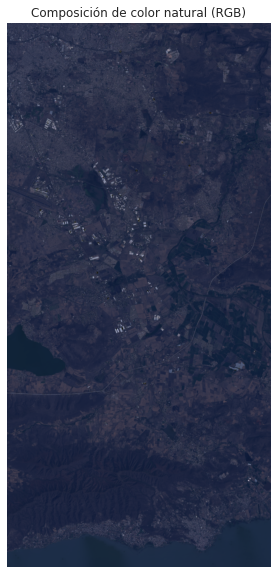

In [20]:
# Ahora veamos cómo obtener una imagen de color natural con las bandas RGB

# Normalizamos las bandas en escala de 0.0 - 1.0
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

# Seleccionamos los array que corresponde a cada banda 
red = arr_img[:,:,3]
green = arr_img[:,:,2]
blue = arr_img[:,:,1]

# Normalizamos con la función 
red_norm = normalize(red)
green_norm = normalize(green)
blue_norm = normalize(blue)

# Realizamos el Stack
rgb = np.dstack((red_norm, green_norm, blue_norm))

# Vemos la composición de color
fig = plt.figure(figsize=(5, 10))
plt.imshow(rgb)
plt.title("Composición de color natural (RGB)")
plt.axis('off');

### **II.I. Análisis exploratorio de datos (EDA)**

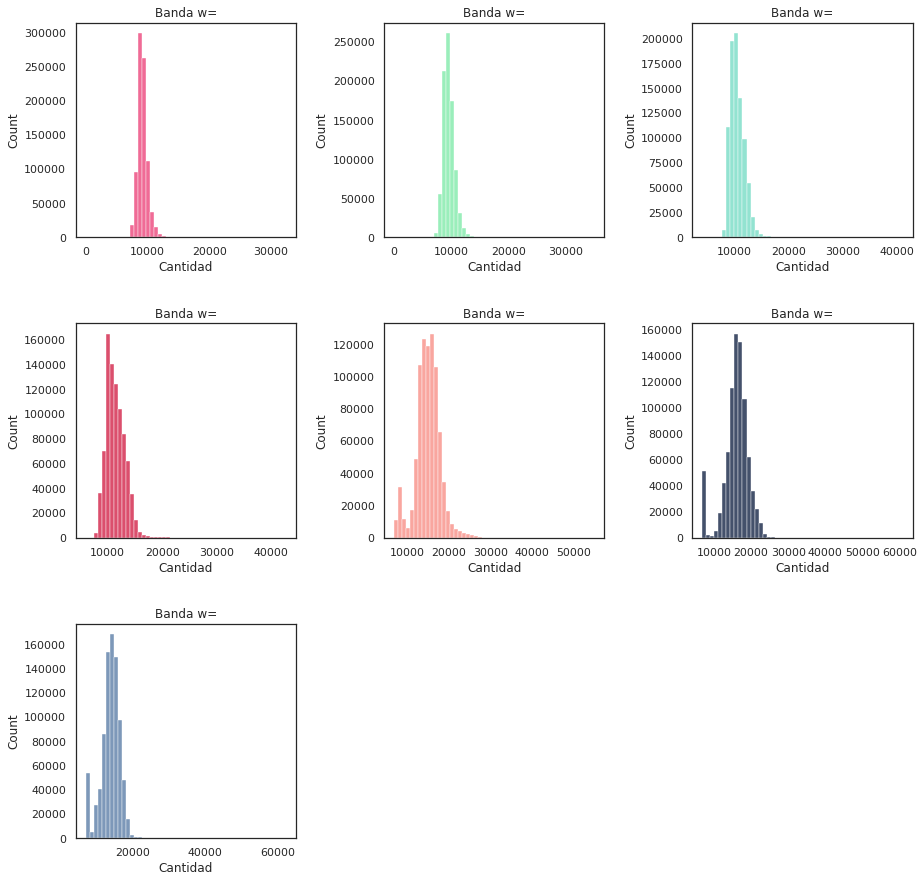

In [21]:
# Ahora analizaremos los histogramas.

fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(1, len(labels) + 1): #
    ax = fig.add_subplot(3, 3, i)
    sns.histplot(arr_img[:,:,i-1].flatten(),
                 color=np.random.rand(3,), bins = 50)
    ax.set_title(f"Banda {labels[i-1]}")
    ax.set(xlabel="Cantidad")

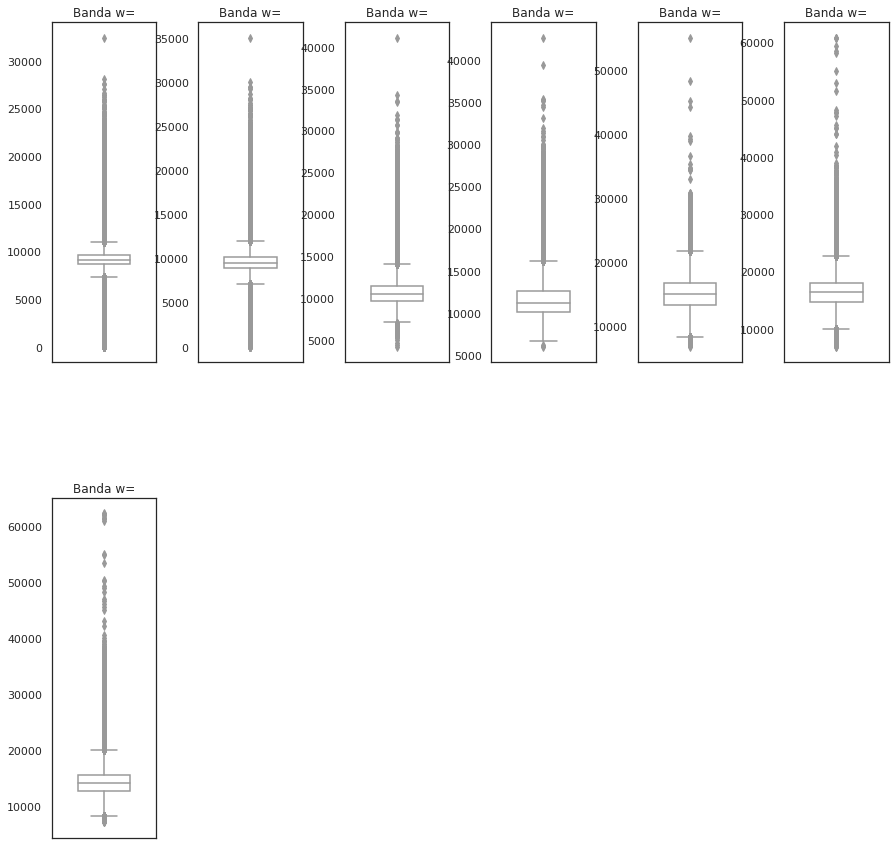

In [22]:
# Veamos los bloxplots

fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(1, len(labels) + 1 ):
    ax = fig.add_subplot(2, 6, i)
    sns.boxplot(y=arr_img[:,:,i-1].flatten(),
                color='white', width=.5)
    ax.set_title(f"Banda {labels[i-1]}")

plt.show()

### **II.II. Estandarización**

Dentro de este apartado realizaremos una estandarización de los datos moviendo la media a 0 y la desviación estandar a la unidad.

In [23]:
# Cargamos nuestra librería
from sklearn.preprocessing import StandardScaler

# Hacemos un reshape para dividir todos los datos de forma lineal, en cada una de las bandas
X_data = arr_img.reshape(-1, 7)

# Realizamos la estandarización
scaler = StandardScaler().fit(X_data)
X_estan = scaler.transform(X_data)
print(f"La nueva dimensión del array es {X_estan.shape}")
1328 * 643


La nueva dimensión del array es (853904, 7)


853904

## **III. Algoritmos no supervisados de Machine Learning**

### **III.I. Clasificación no supervisada: PCA y K-Means Clustering**

En este apartado veremos los resultados que obtenemos a partir de una clasificación no supervisada.

Usaremos el analisis de componentes principales (PCA), así como el método del inercia para poder encontrar el número de componentes que explican la mayor varianza de los datos.

Igualmente, emplearemos la clasificación K-Means Clustering para identificar los conglomerados a partir de los cuales se puede clasificar la imagen de satélite.

In [24]:
%%time

from sklearn.decomposition import PCA

# Análisis de componentes principales, usando los datos previamente preprocesados
pca = PCA(n_components = 6)

pca.fit(X_estan)

data_pca = pca.transform(X_estan)

print("La varianza explicada en cada componente principal es:")
for i in range(0, len(pca.explained_variance_ratio_)):
    print(f"PCA{i+1} = {pca.explained_variance_ratio_[i]}")
print(f"El total de la varianza dentro de las componentes es:\n {np.sum(pca.explained_variance_ratio_)}")

La varianza explicada en cada componente principal es:
PCA1 = 0.7516032502938785
PCA2 = 0.15634839507842674
PCA3 = 0.06986837797460513
PCA4 = 0.01543344511076625
PCA5 = 0.0036784915044556048
PCA6 = 0.0019617267815460336
El total de la varianza dentro de las componentes es:
 0.9988936867436784
CPU times: user 289 ms, sys: 138 ms, total: 427 ms
Wall time: 263 ms


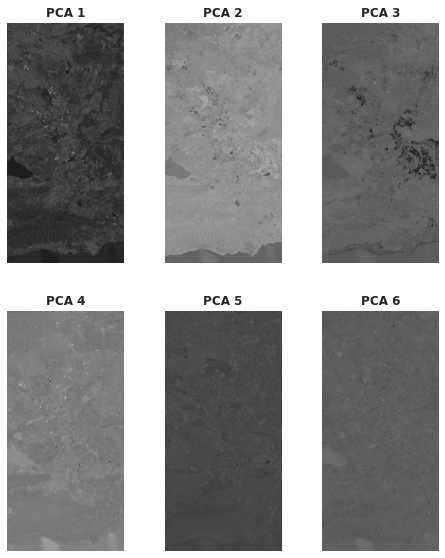

In [25]:
# Vamos a hacer un plot de nuestras PCA
# Primero realizaremos un reshape para regresarlos a la misma 
# forma que los datos originales, y que tengan la misma dimensiones

data_pca_reshape = data_pca.reshape((1328, 643, data_pca.shape[1]))

# Loop para visualizar nuestras componentes
fig = plt.figure(figsize=(8, 15))
for i in range(1, 6+ 1 ):
    ax = fig.add_subplot(3, 3, i)
    show(data_pca_reshape[:,:,i-1], cmap='Greys_r', ax=ax, title=f"PCA {i}")
    plt.axis('off')

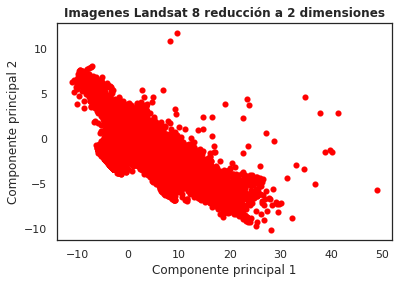

In [26]:
# Ahora graficaremos nuestras dos primeros componentes 

plt.scatter(x=data_pca_reshape[:,:,0], y=data_pca_reshape[:,:,1], color='red',lw=0.1)
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('Imagenes Landsat 8 reducción a 2 dimensiones',fontweight='bold')
plt.show()

In [27]:
# Inercia
import sklearn.cluster as cluster
from tqdm import tqdm

inertia = []
for i in tqdm(range(2,12)):
    kmeans = cluster.KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=50)
    kmeans.fit(data_pca)
    inertia.append(kmeans.inertia_)


100%|██████████| 10/10 [08:40<00:00, 52.07s/it]


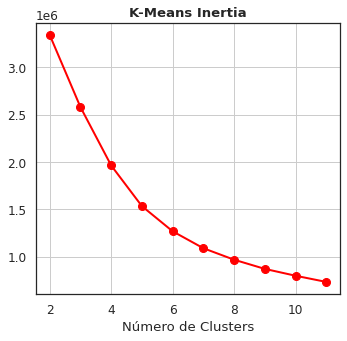

In [28]:
# Finalmente realizamos el plot
sns.set(style='white',font_scale=1.1, rc={'figure.figsize':(12,5)})

plt.subplot(1, 2, 1)

plt.plot(range(2,len(inertia)+2), inertia, marker='o',lw=2,ms=8,color='red')
plt.xlabel('Número de Clusters')
plt.title('K-Means Inertia',fontweight='bold')
plt.grid(True)

A partir de la gráfica anterior, encontramos que debemos realzar la clasificación en 6 componentes. A continuación usaremos el método de k-means para realizar la clasificación.  

Es importante mencionar que esta clasificación sera usada como los "reales del terreno", es decir **y_data**, para poder analizar los algoritmos de Machine learning y así conocer su precisión.

In [29]:
%%time
# Ahora vamos a realizar nuestra clasificación

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=25, init="k-means++")

kmeans.fit(data_pca)

clasificacion = kmeans.predict(data_pca)

CPU times: user 23.5 s, sys: 2.29 s, total: 25.8 s
Wall time: 23.1 s


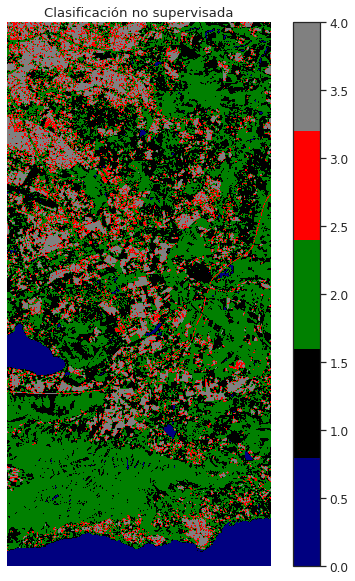

In [30]:
# Veamos nuestros resultados

class_color = ListedColormap(['navy', 'black', 'green', 'red', "grey"])

plt.figure(figsize=(8, 10))
plt.imshow(clasificacion.reshape(1328, 643), cmap=class_color)
plt.title("Clasificación no supervisada")
plt.colorbar()
plt.axis('off');

In [31]:
# Ahora usaremos esta clasificación como "y_data"

y_data = clasificacion

## **IV. Conjuntos de entrenamiento y prueba**

### **IV.I Separación, validación y evaluación para algoritmos de ML**

En esta etapa, realizaremos la separación del dataset entre conjunto de entrenamiento y conjunto de prueba, para clasificar nuestras imágenes.

In [32]:
# Ahora a dividir nuestro array con las imágenes 
from sklearn.model_selection import train_test_split

# Es importante usar el .ravel() pues de esta forma nuestro array tendrá las 
# mismas dimensiones al array con las 12 imágenes de satélite
X_train, X_test, y_train, y_test = train_test_split(X_estan, y_data.ravel(), 
                                  test_size=0.30, stratify = y_data.ravel(), random_state=50)
print(f'Dimensiones X_train: {X_train.shape}\nDimensión X_test: {X_test.shape}\nDimensión y_train: {y_train.shape}\nDimensión y_test:{y_test.shape}')

Dimensiones X_train: (597732, 7)
Dimensión X_test: (256172, 7)
Dimensión y_train: (597732,)
Dimensión y_test:(256172,)


## **V. Algoritmos supervisados de Machine Learning**

### **V.I. Clasificación supervisada: K-Nearest Neighbor Classifier (K-NNC)**

En esta sección aplicamos el algoritmo de clasificación de vecino más próximo (K-NNC), para asignar los datos en grupos, con base en una casificación de puntos dada. 

In [33]:
%%time

# Importamos la librería
from sklearn.neighbors import KNeighborsClassifier

# Hacemos el modelo con 6 clusters, que son los valores clasificados del terreno
knn = KNeighborsClassifier(n_neighbors=6)

# Obtenemos el fit entre los datos de entrenamiento
knn.fit(X_train, y_train)

# Hacemos predicciones
knn_pred = knn.predict(X_test)

CPU times: user 28.4 s, sys: 118 ms, total: 28.6 s
Wall time: 28.4 s


In [34]:
# Calculamos la precisión
from sklearn.metrics import classification_report, accuracy_score

print(f"Precisión: {accuracy_score(y_test, knn_pred)*100}")

# Realizamos el reporte de clasificación
print(classification_report(y_test, knn_pred))

Precisión: 99.25635900879098
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17794
           1       0.99      1.00      0.99     92138
           2       1.00      0.99      0.99     91426
           3       0.98      0.99      0.98      1632
           4       1.00      0.99      0.99     53182

    accuracy                           0.99    256172
   macro avg       0.99      0.99      0.99    256172
weighted avg       0.99      0.99      0.99    256172



CPU times: user 1min 17s, sys: 283 ms, total: 1min 18s
Wall time: 1min 17s


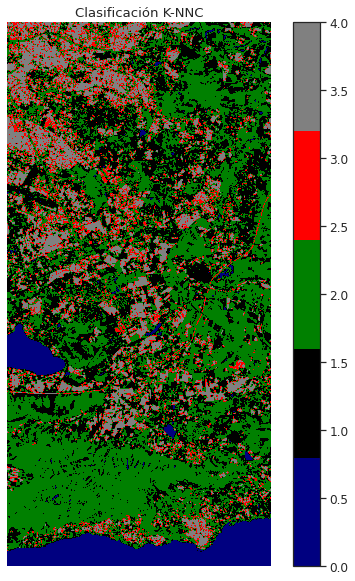

In [35]:
%%time

# Vamos a ver nuestros resultados

plt.figure(figsize=(8, 10))
plt.imshow(knn.predict(X_estan).reshape((1328, 643)), cmap=class_color) #
plt.title("Clasificación K-NNC")
plt.colorbar()
plt.axis('off');

### **V.II. Clasificación supervisada: Árboles de decisión**

Ahora usaremos arboles de decisión (Decision Trees) para observar cómo nuestra clasificación puede variar o no de los datos del terreno. De igual forma, analizar el tiempo de cómputo requerido para esta clasificación.

In [36]:
%%time

# Importamos la librería
from sklearn.tree import DecisionTreeClassifier

# Agregamos el modelo
dtc = DecisionTreeClassifier()

# Realizamos nuestra clasificación usando los datos de entrenamiento
dtc = dtc.fit(X_train, y_train)

# Predicción en los datos de prueba
dtc_pred = dtc.predict(X_test)

CPU times: user 7.24 s, sys: 2.23 ms, total: 7.24 s
Wall time: 7.22 s


In [37]:
# Calculamos la precisión
print(f"Precisión: {accuracy_score(y_test, dtc_pred)*100}")

# Realizamos el reporte de clasificación
print(classification_report(y_test, dtc_pred))

Precisión: 98.15865902596693
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17794
           1       0.98      0.98      0.98     92138
           2       0.99      0.99      0.99     91426
           3       0.97      0.97      0.97      1632
           4       0.98      0.98      0.98     53182

    accuracy                           0.98    256172
   macro avg       0.98      0.98      0.98    256172
weighted avg       0.98      0.98      0.98    256172



CPU times: user 137 ms, sys: 975 µs, total: 138 ms
Wall time: 136 ms


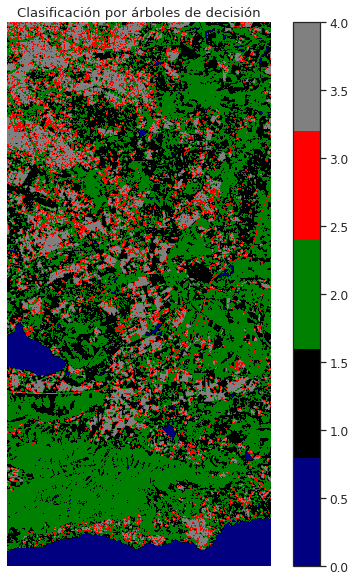

In [38]:
%%time

# Vamos a ver nuestros resultados, y la clasificación de todos los datos

plt.figure(figsize=(8, 10))
plt.imshow(dtc.predict(X_estan).reshape((1328, 643)), cmap=class_color) #
plt.title("Clasificación por árboles de decisión")
plt.colorbar()
plt.axis('off');

#### **V.II.I. Árboles de decisión: Random Forest**

De manera similar, ahora usaremos el Random Forest para analizar nuestra clasificación.

In [39]:
%%time

# Importamos la librería
from sklearn.ensemble import RandomForestClassifier

# Agregamos el modelo
rfc = RandomForestClassifier()

# Realizamos nuestra clasificación usando los datos de entrenamiento
rfc = rfc.fit(X_train, y_train)

# Predicción en los datos de prueba
rfc_pred = rfc.predict(X_test)

CPU times: user 2min 48s, sys: 317 ms, total: 2min 48s
Wall time: 2min 48s


In [40]:
# Calculamos la precisión
print(f"Precisión: {accuracy_score(y_test, rfc_pred)*100}")

# Realizamos el reporte de clasificación
print(classification_report(y_test, rfc_pred))

Precisión: 99.27158315506769
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17794
           1       0.99      0.99      0.99     92138
           2       0.99      0.99      0.99     91426
           3       0.99      0.98      0.99      1632
           4       0.99      0.99      0.99     53182

    accuracy                           0.99    256172
   macro avg       0.99      0.99      0.99    256172
weighted avg       0.99      0.99      0.99    256172



CPU times: user 11.7 s, sys: 59.4 ms, total: 11.7 s
Wall time: 11.7 s


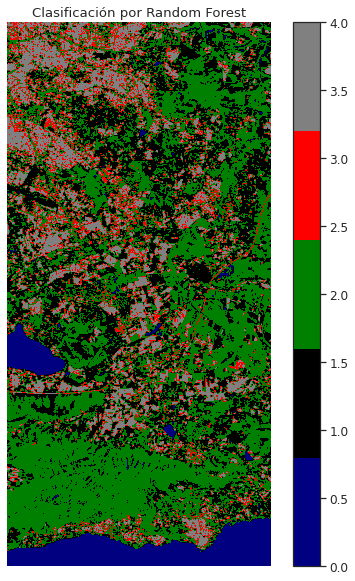

In [41]:
%%time

# Vamos a ver nuestros resultados, y la clasificación de todos los datos

plt.figure(figsize=(8, 10))
plt.imshow(rfc.predict(X_estan).reshape((1328, 643)), cmap=class_color) #
plt.title("Clasificación por Random Forest")
plt.colorbar()
plt.axis('off');

#### **V.II.II. Árboles de decisión: Decision Tree Regression**

En esta parte, aplicamos un modelo de clasificación en forma de estructura de árbol de decisión.

In [42]:
%%time
# importamos el Decision Tree Regresion
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()

# Realizamos nuestra clasificación usando los datos de entrenamiento
dtr = dtr.fit(X_train, y_train)

# Predicción en los datos de prueba
dtr_pred = dtr.predict(X_test)

CPU times: user 7.23 s, sys: 5.7 ms, total: 7.24 s
Wall time: 7.23 s


In [43]:
# Calculamos la precisión
print(f"Precisión: {accuracy_score(y_test, dtr_pred)*100}")

# Realizamos el reporte de clasificación
print(classification_report(y_test, dtr_pred))

Precisión: 98.18364224036975
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17794
           1       0.98      0.98      0.98     92138
           2       0.99      0.99      0.99     91426
           3       0.97      0.97      0.97      1632
           4       0.98      0.98      0.98     53182

    accuracy                           0.98    256172
   macro avg       0.98      0.98      0.98    256172
weighted avg       0.98      0.98      0.98    256172



CPU times: user 120 ms, sys: 1.29 ms, total: 121 ms
Wall time: 124 ms


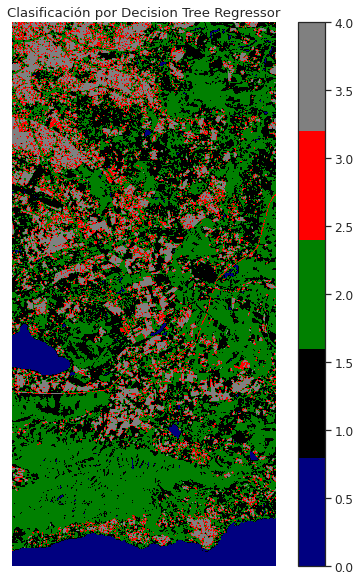

In [44]:
%%time

# Vamos a ver nuestros resultados, y la clasificación de todos los datos

plt.figure(figsize=(8, 10))
plt.imshow(dtr.predict(X_estan).reshape((1328, 643)), cmap=class_color) #
plt.title("Clasificación por Decision Tree Regressor")
plt.colorbar()
plt.axis('off');

#### **V.II.III. Árboles de decisión: Decision Tree Regression con AdaBoost**

Este algoritmo funciona de la misma forma que el anterior, pero tiene diferentes estimadores, es decir, usa más árboles de decisión (boosts) para que la regresión se ajuste con mayor detalle.

In [45]:
%%time
# Importamos AdaBoost
from sklearn.ensemble import AdaBoostRegressor

# Usaremos un modelo con 200 árboles de decisión
adtr = AdaBoostRegressor(DecisionTreeRegressor(), n_estimators=50, random_state=25)

# Realizamos nuestra clasificación usando los datos de entrenamiento
adtr = adtr.fit(X_train, y_train)

# Predicción en los datos de prueba
adtr_pred = adtr.predict(X_test)


CPU times: user 2min 37s, sys: 657 ms, total: 2min 38s
Wall time: 2min 37s


In [46]:
# Calculamos la precisión
print(f"Precisión: {accuracy_score(y_test, adtr_pred)*100}")

# Realizamos el reporte de clasificacion
print(classification_report(y_test, adtr_pred))

Precisión: 99.36683165997844
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17794
           1       0.99      0.99      0.99     92138
           2       1.00      1.00      1.00     91426
           3       0.99      0.98      0.99      1632
           4       0.99      0.99      0.99     53182

    accuracy                           0.99    256172
   macro avg       0.99      0.99      0.99    256172
weighted avg       0.99      0.99      0.99    256172



CPU times: user 5.26 s, sys: 293 ms, total: 5.55 s
Wall time: 5.54 s


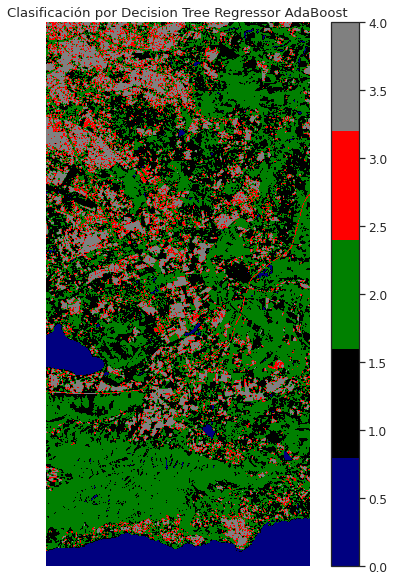

In [47]:
%%time

# Vamos a ver nuestros resultados, y la clasificación de todos los datos

plt.figure(figsize=(8, 10))
plt.imshow(adtr.predict(X_estan).reshape((1328, 643)), cmap=class_color) #
plt.title("Clasificación por Decision Tree Regressor AdaBoost")
plt.colorbar()
plt.axis('off');

### **V.III. Clasifiación supervisada: Redes Neuronales Artificiales**

En esta parte, realizamos una red neuronal artificial a partir de un perceptrón multicapa (MLPC) que clasifica a partir de umbrales de activación.

In [48]:
%%time

# Importamos la librería
from sklearn.neural_network import MLPClassifier

# Agregamos el modelo
ann = MLPClassifier(hidden_layer_sizes=(4,2),
                            max_iter=1000,
                            activation ='relu',
                            tol= 0.0001)

# Realizamos nuestra clasificación usando los datos de entrenamiento
ann = ann.fit(X_train, y_train)

# Predicción en los datos de prueba
ann_pred = ann.predict(X_test)

CPU times: user 2min 27s, sys: 548 ms, total: 2min 28s
Wall time: 2min 27s


In [49]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, ann_pred)

# Calculamos las métricas
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

print(f"Precisión PPV: {precision_score(y_test, ann_pred, average=None)*100}")
print(f"Exactitud ACC: {accuracy_score(y_test, ann_pred)*100}")
print(f"Sensibilidad TPR: {recall_score(y_test, ann_pred, average=None)*100}")

# Realizamos el reporte de clasificación
print(classification_report(y_test, ann_pred))

Precisión PPV: [98.4088263  99.99673381 99.95401191 98.585209   99.54683345]
Exactitud ACC: 99.76734381587372
Sensibilidad TPR: [99.75272564 99.6841694  99.84687069 93.93382353 99.95863262]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     17794
           1       1.00      1.00      1.00     92138
           2       1.00      1.00      1.00     91426
           3       0.99      0.94      0.96      1632
           4       1.00      1.00      1.00     53182

    accuracy                           1.00    256172
   macro avg       0.99      0.99      0.99    256172
weighted avg       1.00      1.00      1.00    256172



CPU times: user 366 ms, sys: 138 ms, total: 504 ms
Wall time: 318 ms


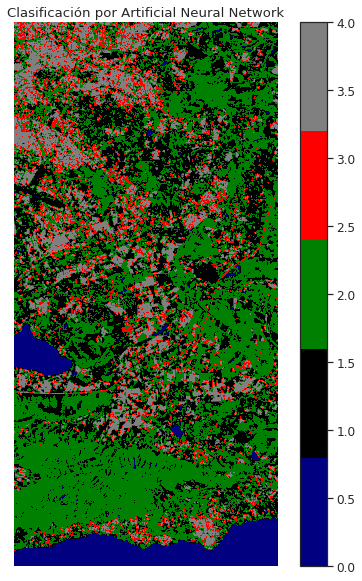

In [50]:
%%time

# Vamos a ver nuestros resultados, y la clasificación de todos los datos

plt.figure(figsize=(8, 10))
plt.imshow(ann.predict(X_estan).reshape((1328, 643)), cmap=class_color) #
plt.title("Clasificación por Artificial Neural Network")
plt.colorbar()
plt.axis('off');

### **V.IV. Clasifiación supervisada: Maquina de Soporte Vectorial**

Siguiendo con los modelos de clasificación, ahora se realiza una clasificación de los umbrales por medio de una SVM. 

*   Elemento de lista
*   Elemento de lista





In [51]:
%%time 

#importo el modelo de Sklearn: 
from sklearn.svm import SVC #Support Vector Classifier

#agrego el modelo: 

modelo_SVC = SVC()

# Realizamos nuestra clasificación usando los datos de entrenamiento

entrenamiento = modelo_SVC.fit(X_train, y_train)

# Predicción en los datos de prueba
prediccion = entrenamiento.predict(X_test)

print(f"Precisión PPV: {precision_score(y_test, prediccion, average=None)*100}")
print(f"Exactitud ACC: {accuracy_score(y_test, prediccion)*100}")
print(f"Sensibilidad TPR: {recall_score(y_test, prediccion, average=None)*100}")

# Realizamos el reporte de clasificación
print(classification_report(y_test, prediccion))



Precisión PPV: [99.96622953 99.95766208 99.925666   99.50950337 99.93606499]
Exactitud ACC: 99.93949377761815
Sensibilidad TPR: [99.81454423 99.93379496 99.98359329 99.44852941 99.93042759]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17794
           1       1.00      1.00      1.00     92138
           2       1.00      1.00      1.00     91426
           3       1.00      0.99      0.99      1632
           4       1.00      1.00      1.00     53182

    accuracy                           1.00    256172
   macro avg       1.00      1.00      1.00    256172
weighted avg       1.00      1.00      1.00    256172

CPU times: user 8min 56s, sys: 798 ms, total: 8min 57s
Wall time: 8min 55s


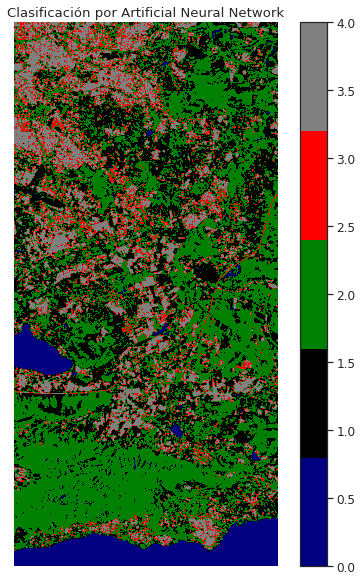

In [52]:
%%time 
# Visualizamos nuestros resultados: 

plt.figure(figsize=(8, 10))
plt.imshow(entrenamiento.predict(X_estan).reshape((1328, 643)), cmap=class_color) #
plt.title("Clasificación por Artificial Neural Network")
plt.colorbar()
plt.axis('off');

### **V.V. Clasifiación supervisada: Naïve Bayes**

In [53]:
%%time 

#importo el modelo Naïve Bayes
from sklearn.naive_bayes import GaussianNB

naiv = GaussianNB()

naiv_fit = naiv.fit(X_train, y_train)

naiv_pred = naiv_fit.predict(X_test)

print(f"Precisión PPV: {precision_score(y_test, naiv_pred, average=None)*100}")
print(f"Exactitud ACC: {accuracy_score(y_test, naiv_pred)*100}")
print(f"Sensibilidad TPR: {recall_score(y_test, naiv_pred, average=None)*100}")

# Realizamos el reporte de clasificación
print(classification_report(y_test, naiv_pred))

Precisión PPV: [99.98203162 97.68901665 96.72111614 54.6184739  94.21412631]
Exactitud ACC: 96.23963586965007
Sensibilidad TPR: [ 93.81252107  94.41815538  97.66477807 100.          97.64205934]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     17794
           1       0.98      0.94      0.96     92138
           2       0.97      0.98      0.97     91426
           3       0.55      1.00      0.71      1632
           4       0.94      0.98      0.96     53182

    accuracy                           0.96    256172
   macro avg       0.89      0.97      0.91    256172
weighted avg       0.97      0.96      0.96    256172

CPU times: user 813 ms, sys: 10.8 ms, total: 824 ms
Wall time: 824 ms


CPU times: user 276 ms, sys: 6.87 ms, total: 283 ms
Wall time: 283 ms


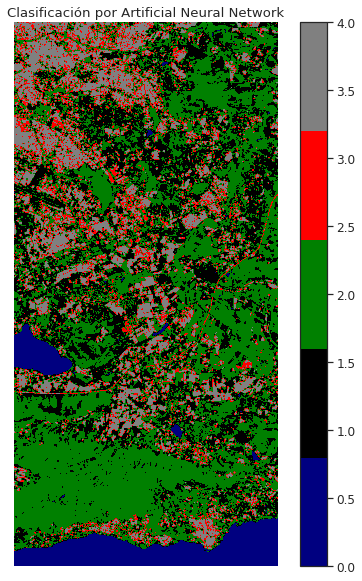

In [54]:
%%time 
# Visualizamos nuestros resultados: 

plt.figure(figsize=(8, 10))
plt.imshow(naiv_fit.predict(X_estan).reshape((1328, 643)), cmap=class_color) #
plt.title("Clasificación por Artificial Neural Network")
plt.colorbar()
plt.axis('off');